In [310]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [311]:
train_data = pl.read_csv("train_data.csv")
test_data = pl.read_csv("test_data.csv")
train_data.shape,test_data.shape

((4923, 19), (2109, 19))

In [312]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

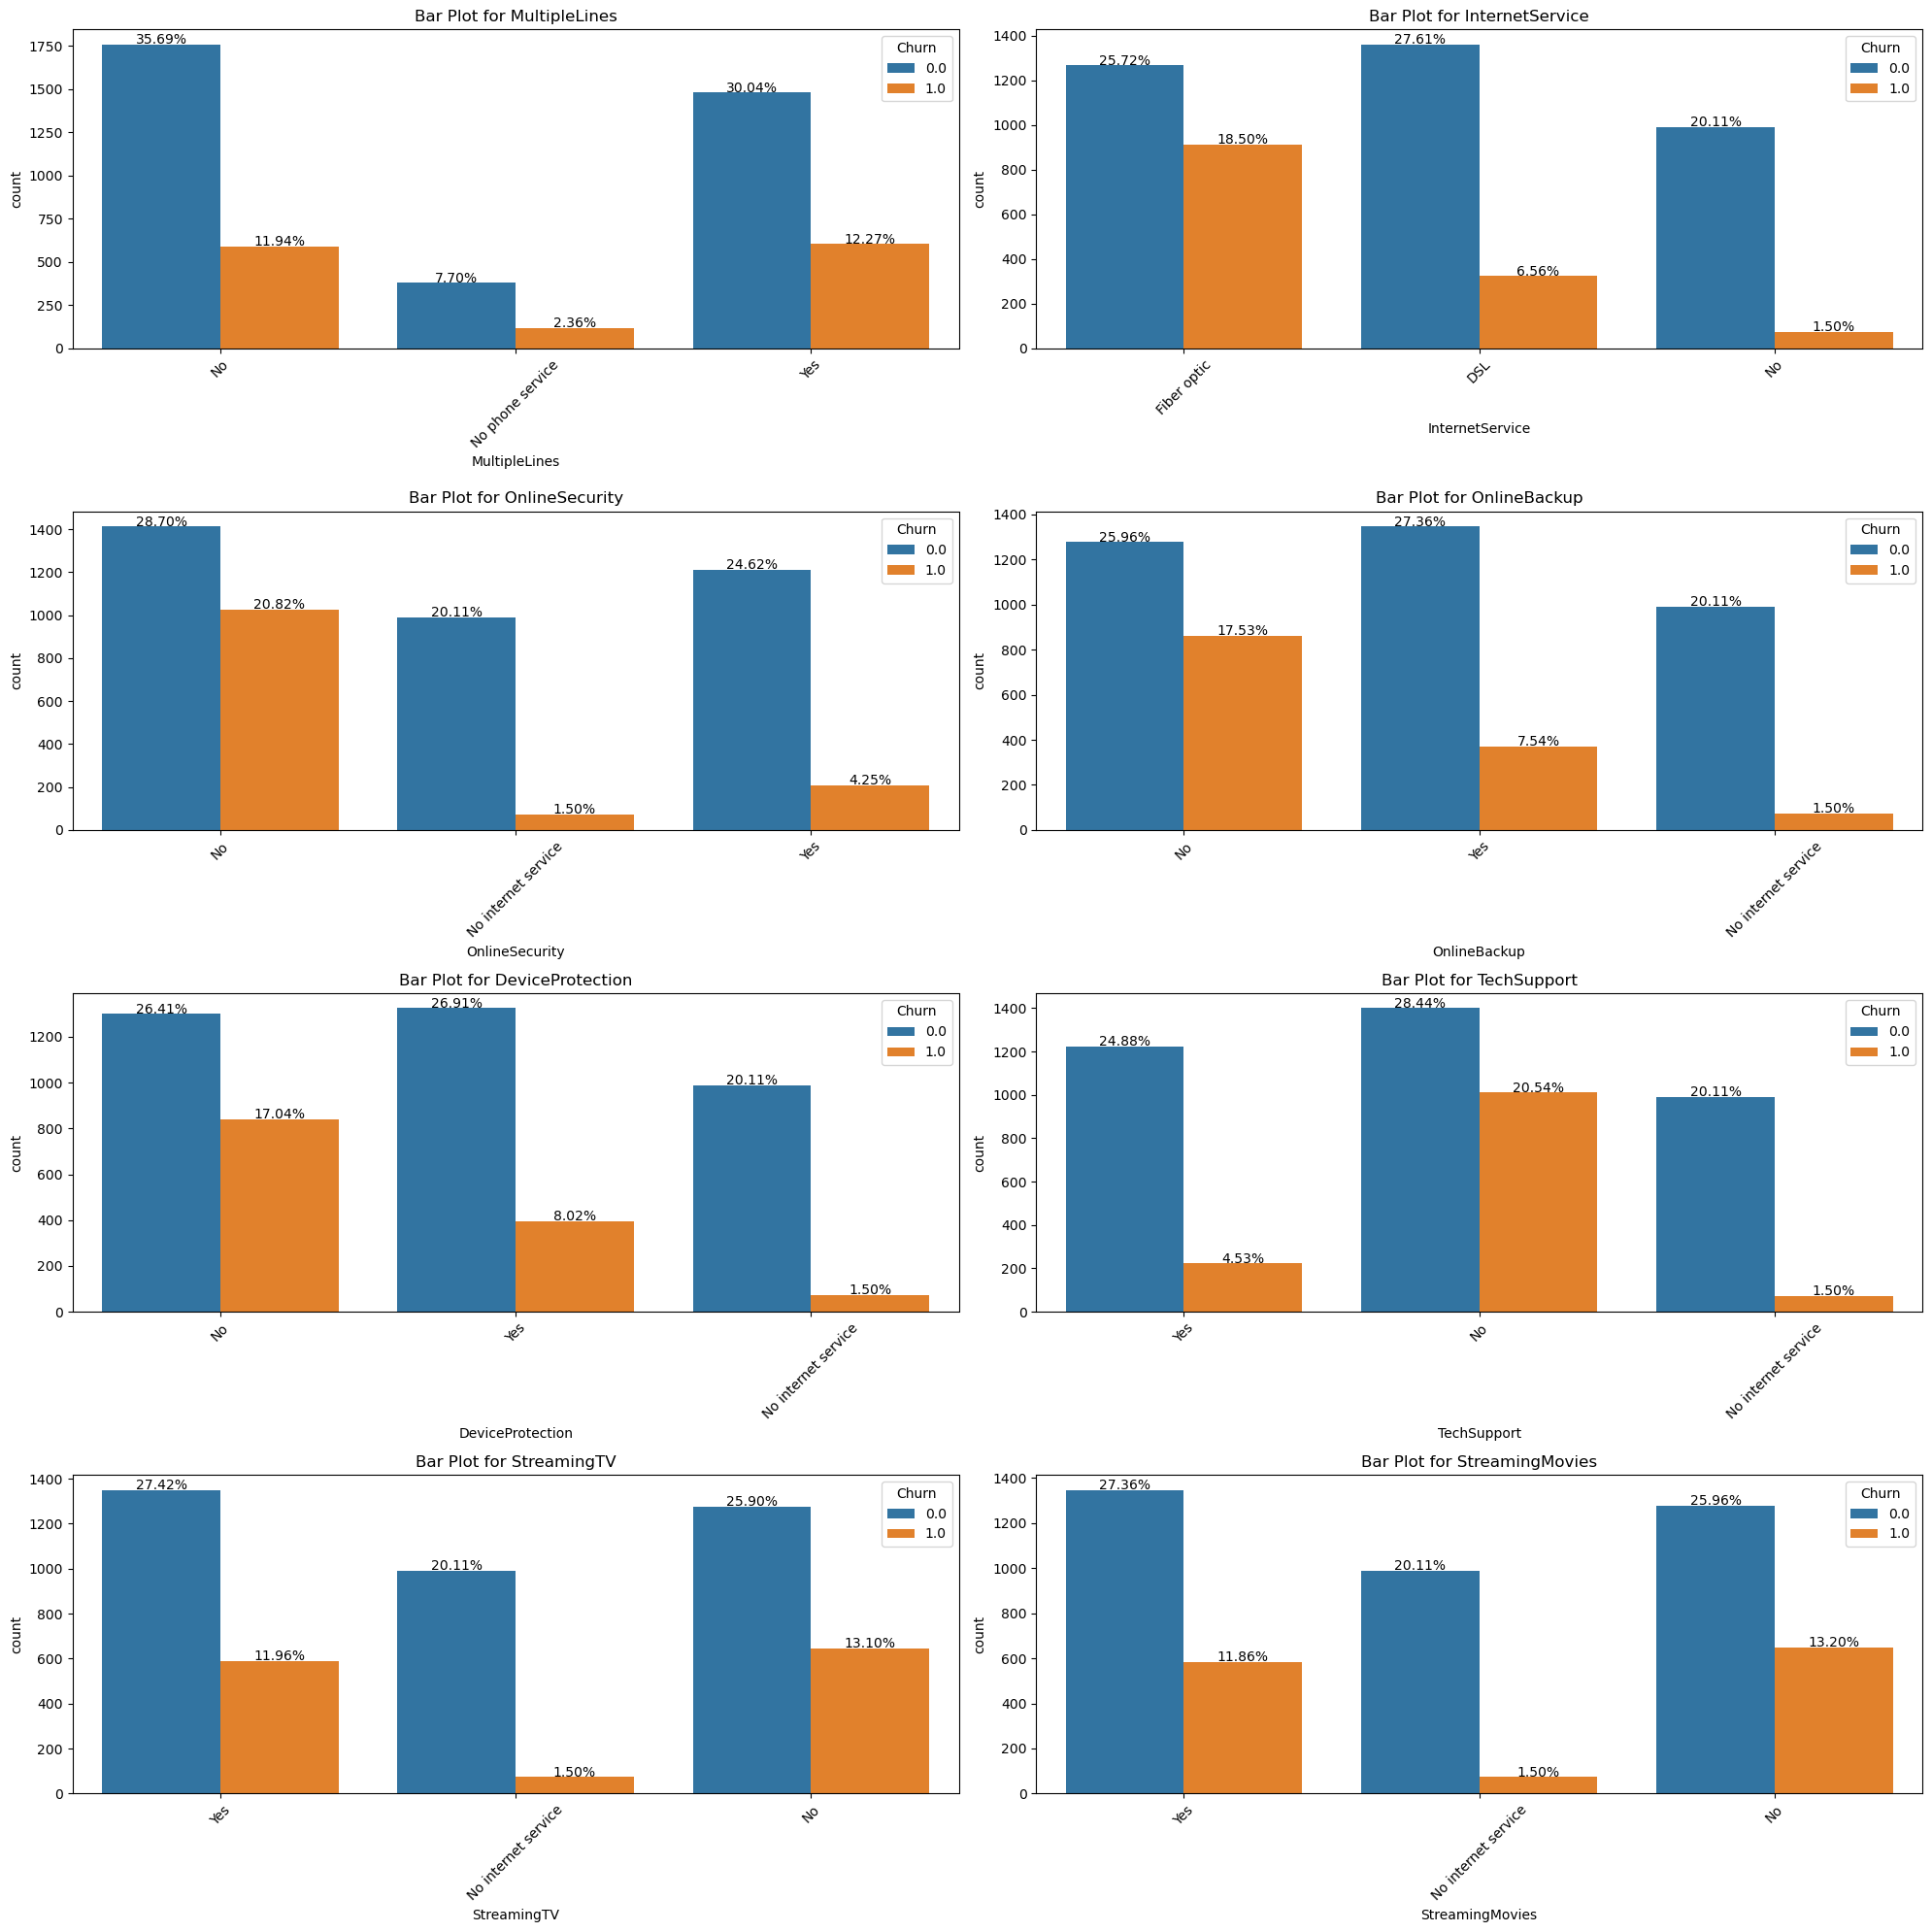

In [313]:
categorical_hist_plot(train_data.to_pandas(),cat_cols,"Churn")

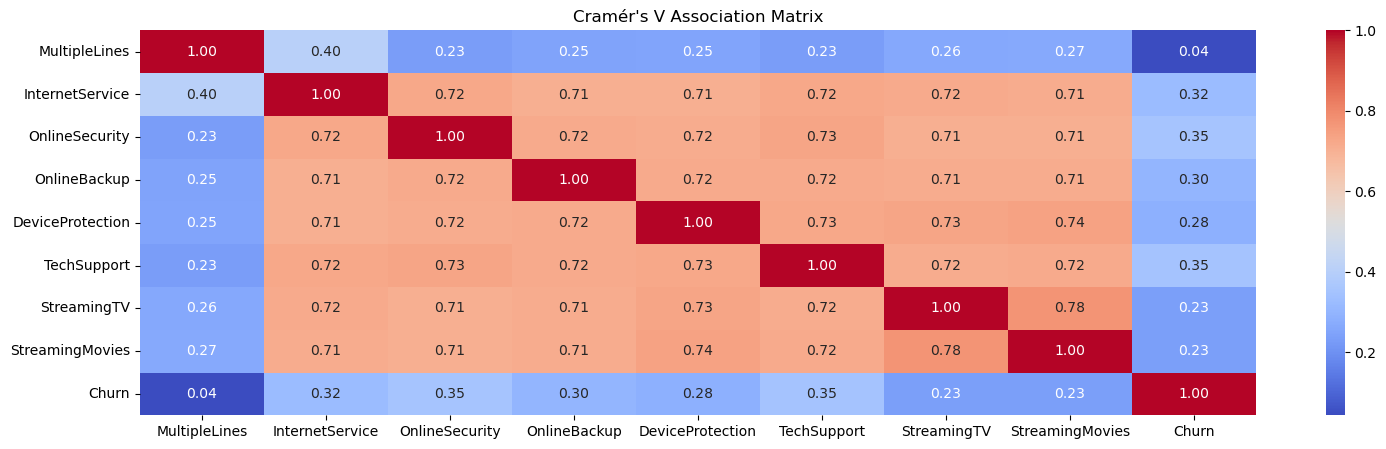

In [314]:
matrix = cramers_v_matrix(train_data,cat_cols+["Churn"])
plot_heatmap(matrix,cat_cols+["Churn"])

In [315]:
# train_data=train_data.with_columns(train_data['OnlineSecurity'].is_in(["Yes"]).cast(pl.Int8))
# train_data=train_data.with_columns(train_data['OnlineBackup'].is_in(["Yes"]).cast(pl.Int8))
# train_data=train_data.with_columns(train_data['DeviceProtection'].is_in(["Yes"]).cast(pl.Int8))
# train_data=train_data.with_columns(train_data['TechSupport'].is_in(["Yes"]).cast(pl.Int8))

# test_data=test_data.with_columns(test_data['OnlineSecurity'].is_in(["Yes"]).cast(pl.Int8))
# test_data=test_data.with_columns(test_data['OnlineBackup'].is_in(["Yes"]).cast(pl.Int8))
# test_data=test_data.with_columns(test_data['DeviceProtection'].is_in(["Yes"]).cast(pl.Int8))
# test_data=test_data.with_columns(test_data['TechSupport'].is_in(["Yes"]).cast(pl.Int8))

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

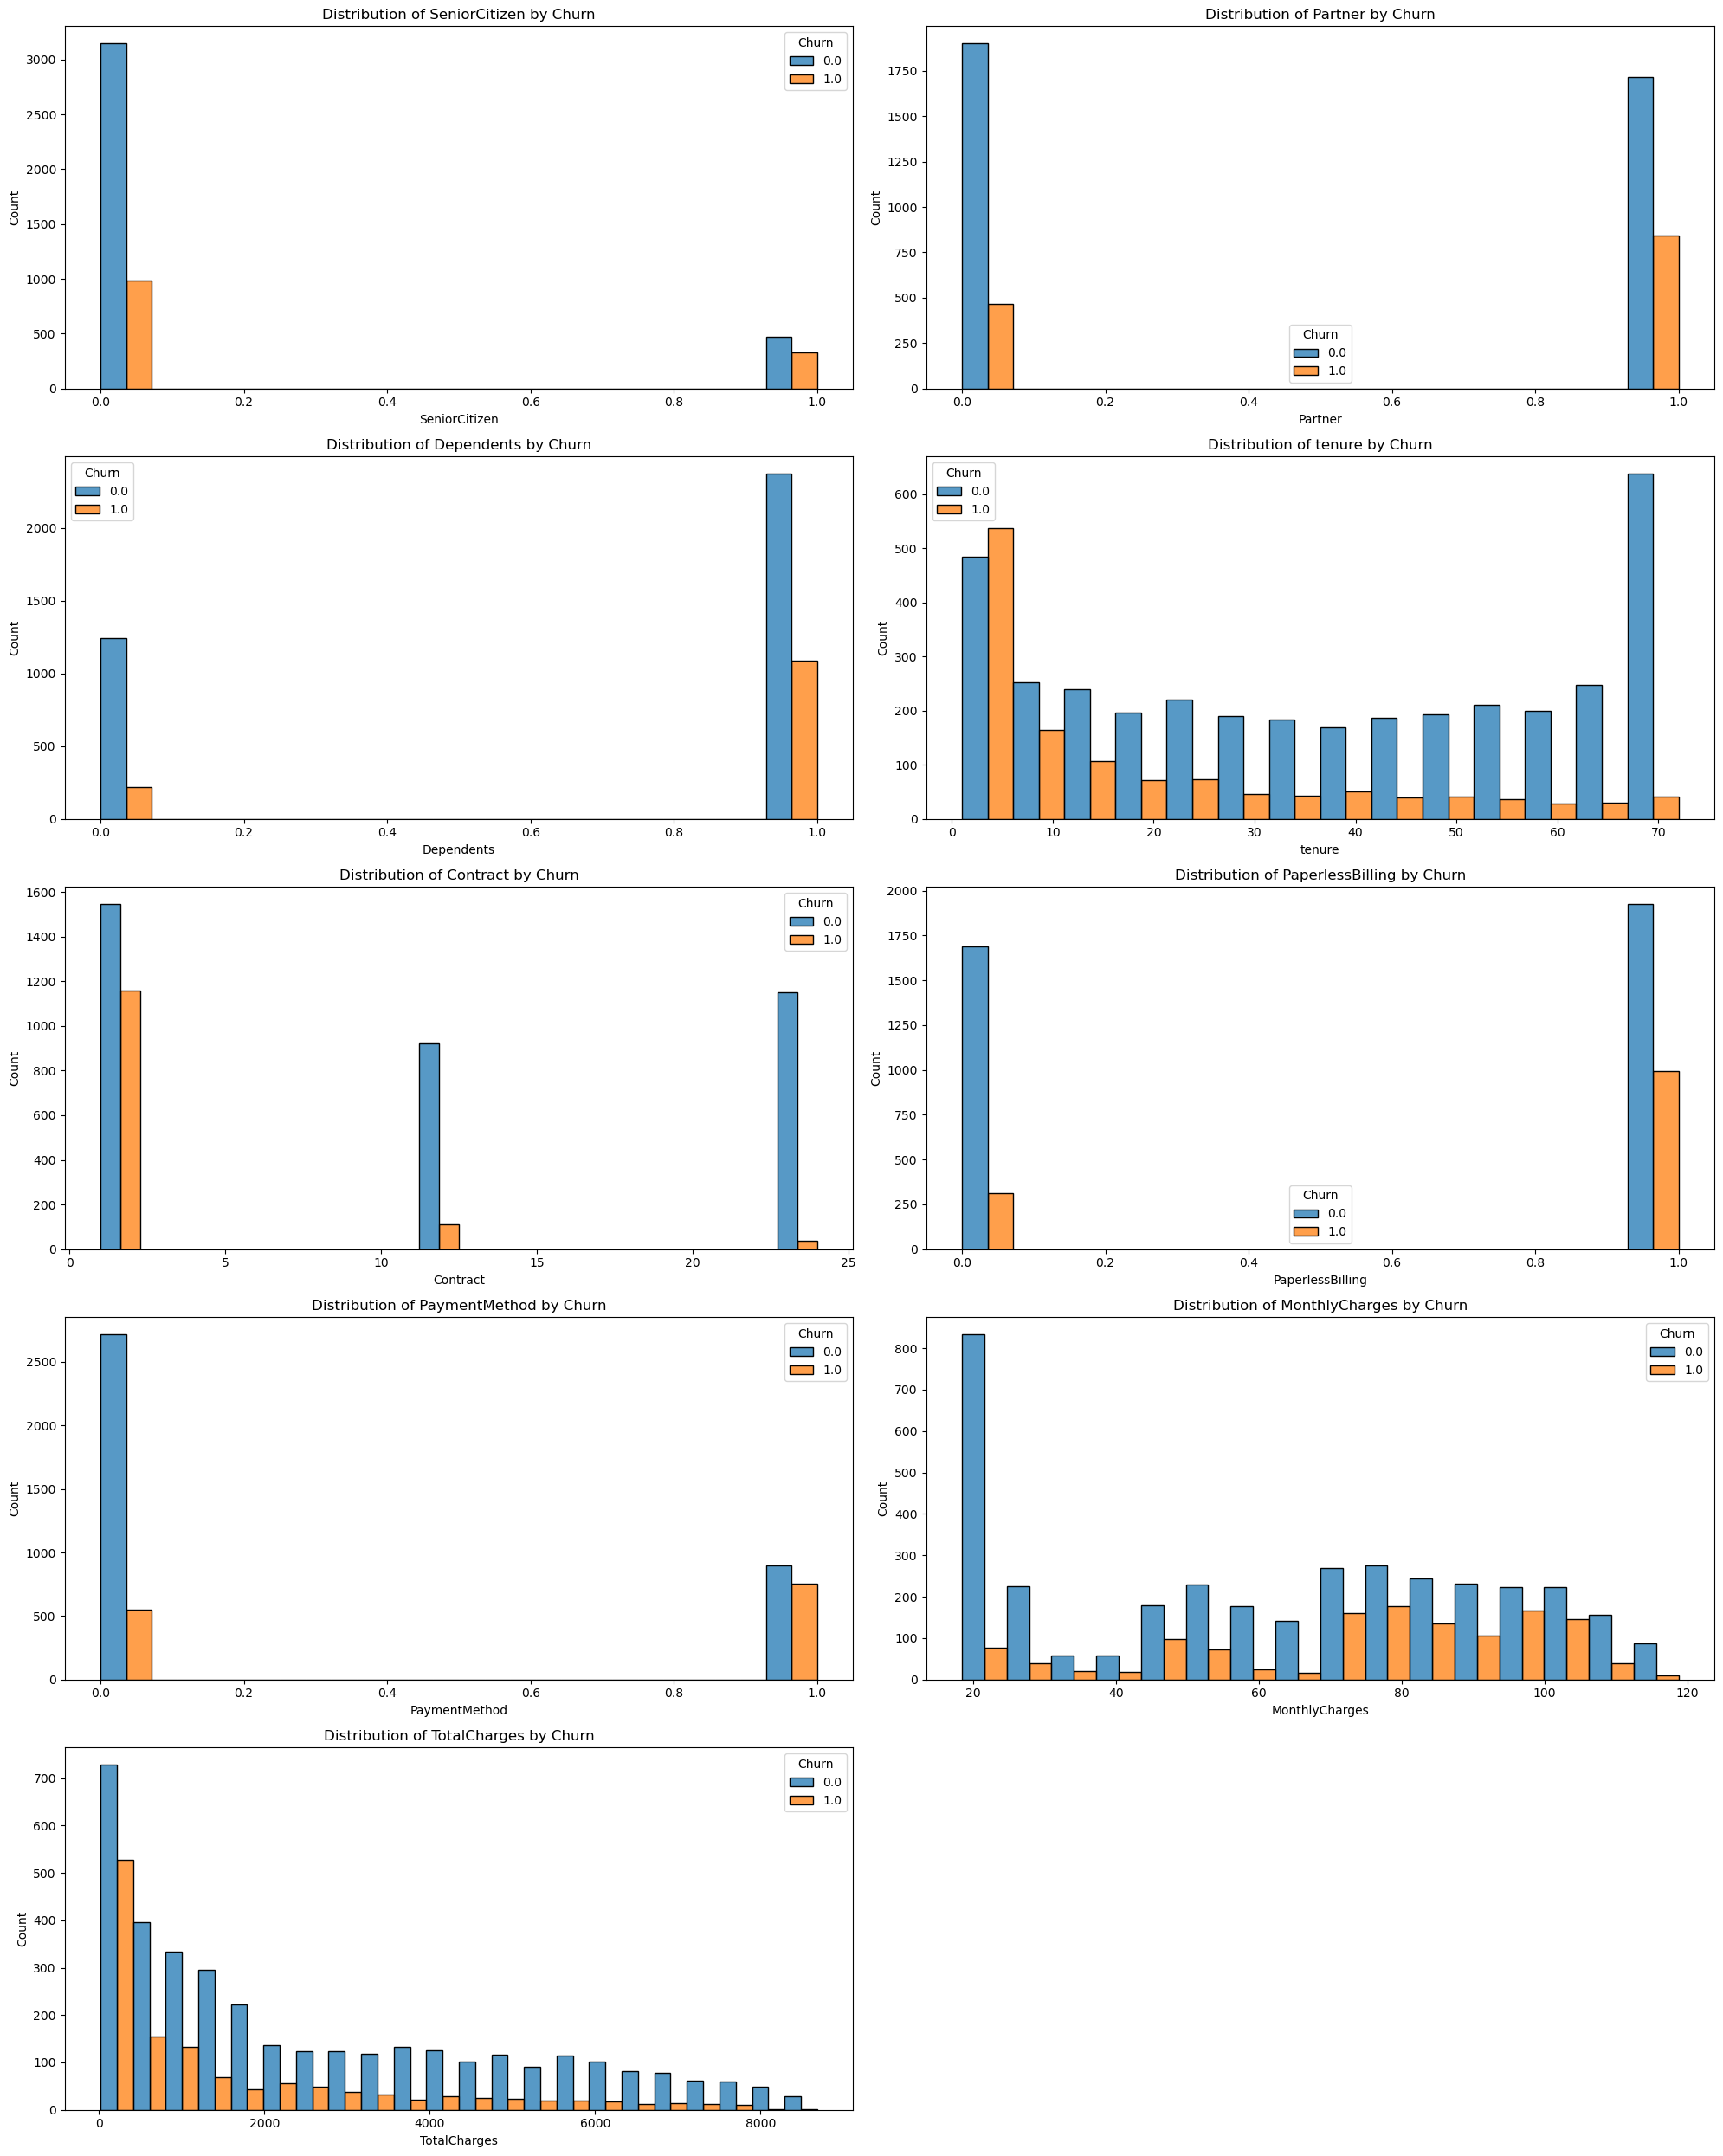

In [316]:
num_dodge_plot(train_data,num_cols,"Churn")

Non Binary Features

In [317]:
non_binary_cols=[col for col in num_cols if len(train_data[col].unique())>2]
non_binary_cols

['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']

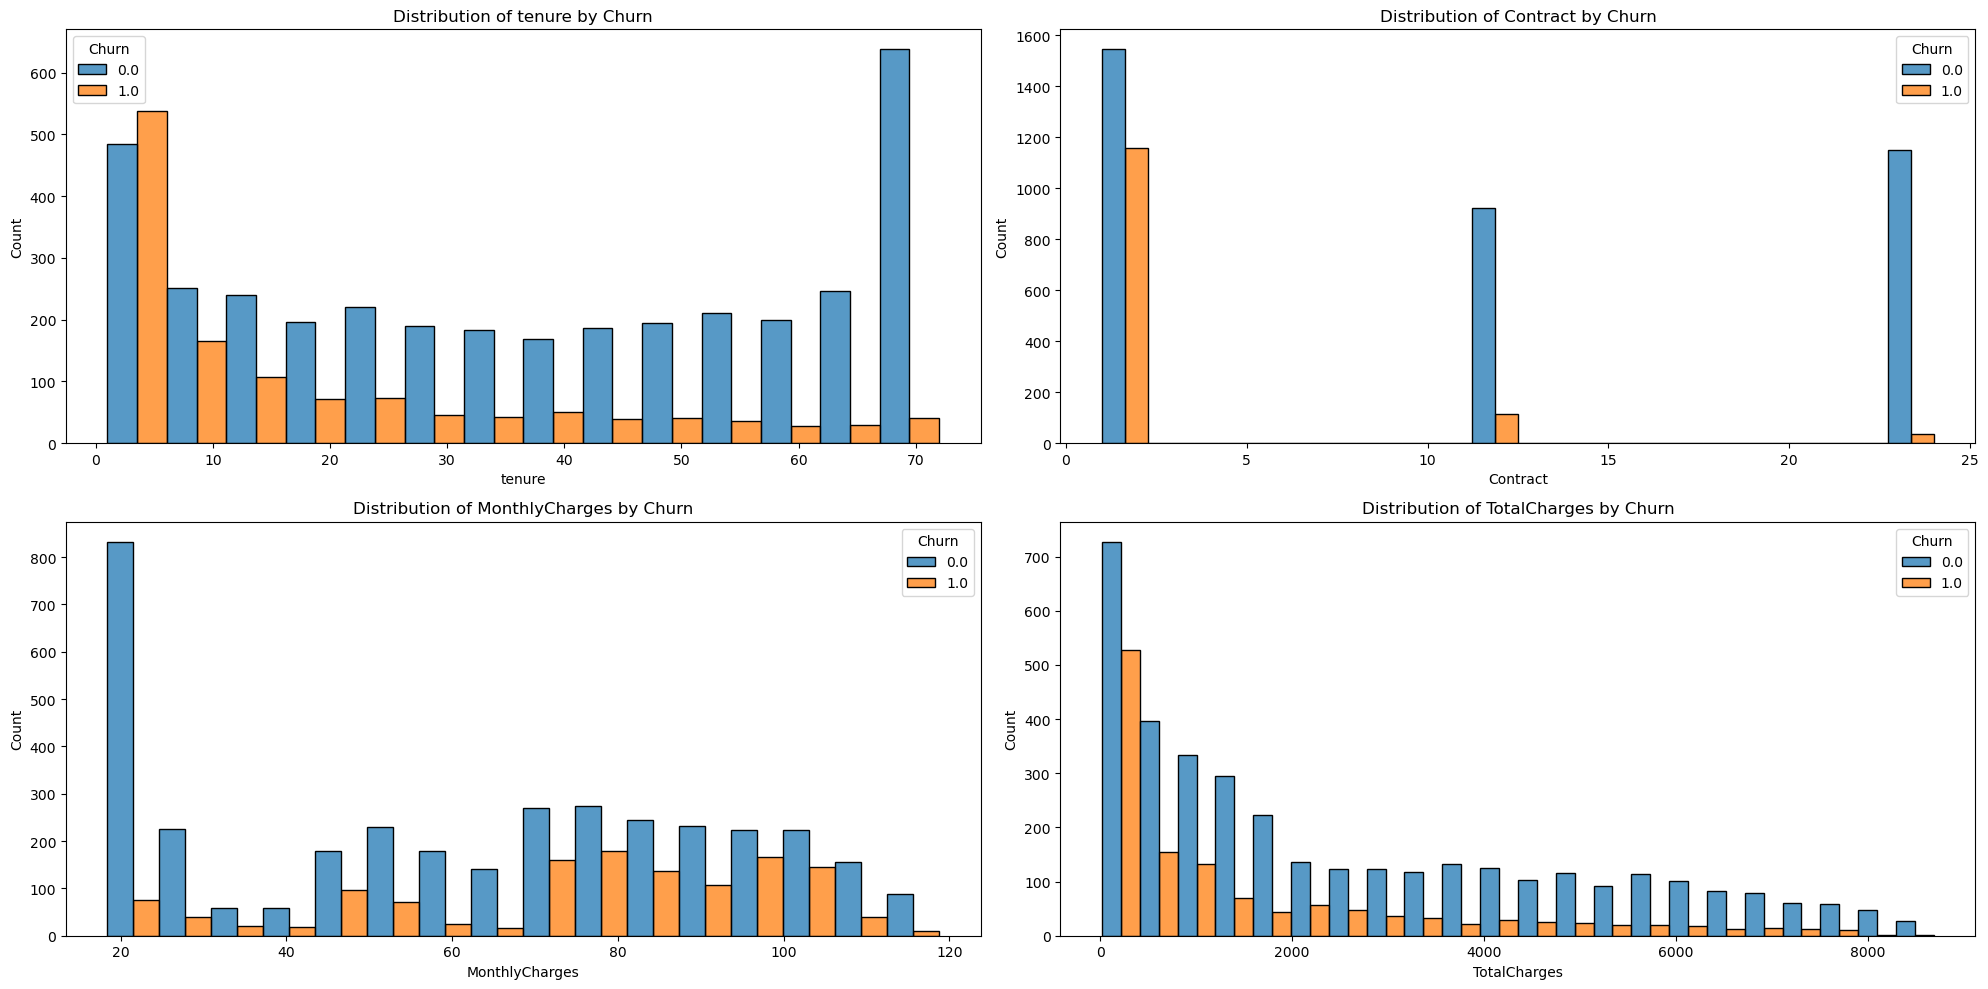

In [318]:
num_dodge_plot(train_data,non_binary_cols,"Churn")

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

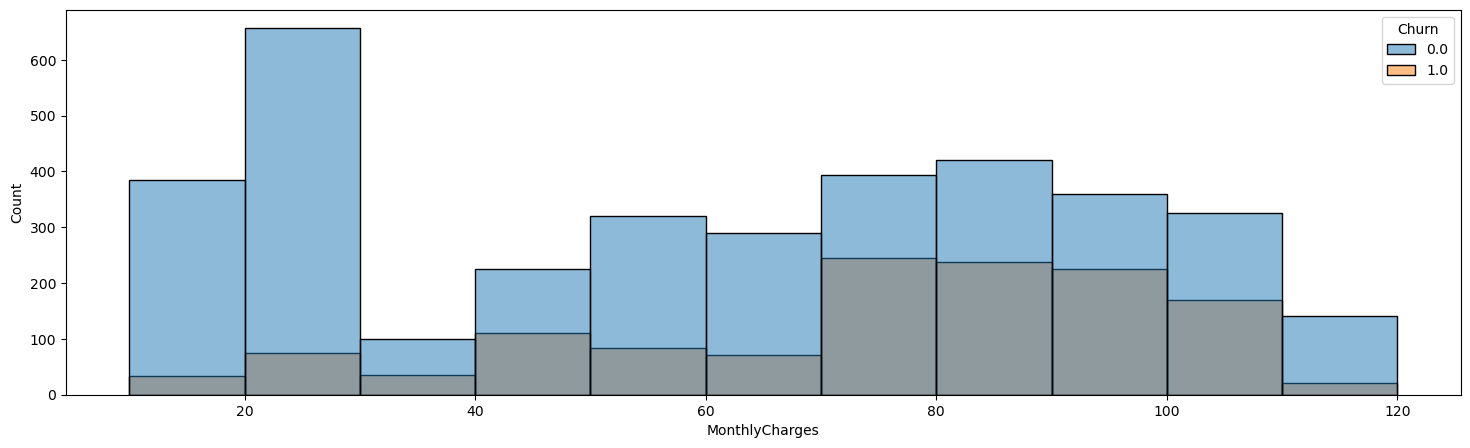

In [319]:
plt.figure(figsize=(18,5))
sns.histplot(train_data,x="MonthlyCharges",hue="Churn",bins=np.arange(10,130,10))

In [320]:
train_data=train_data.with_columns(train_data["MonthlyCharges"].is_between(75,100).cast(pl.Int8).alias("MonthlyChargesBin"))
test_data=test_data.with_columns(test_data["MonthlyCharges"].is_between(75,100).cast(pl.Int8).alias("MonthlyChargesBin"))

<Axes: xlabel='tenure', ylabel='Count'>

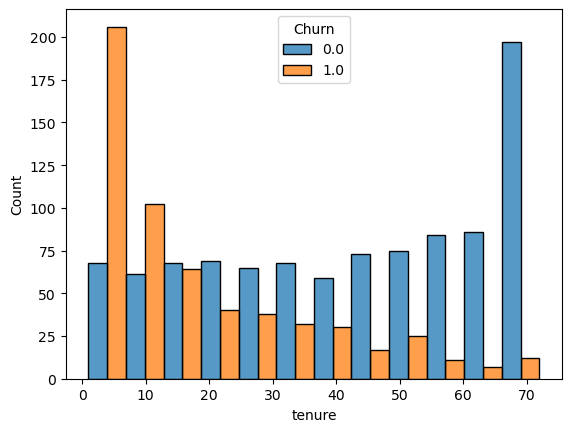

In [321]:
sns.histplot(train_data,x=train_data["tenure"]/train_data["MonthlyChargesBin"],hue="Churn",multiple="dodge")

In [322]:
plt.figure(figsize=(18,5))
px.scatter(x=train_data["tenure"].pow(.5)/(train_data['MonthlyCharges'].pow(.1)/train_data["TotalCharges"].pow(.1)),color=train_data["Churn"])

<Figure size 1800x500 with 0 Axes>

In [323]:
train_data=train_data.with_columns(pl.Series(train_data["tenure"].pow(.2)/(train_data['MonthlyCharges'].pow(1)/train_data["TotalCharges"].pow(.3))).alias("fe1"))
test_data=test_data.with_columns(pl.Series(test_data["tenure"].pow(.2)/(test_data['MonthlyCharges'].pow(1)/test_data["TotalCharges"].pow(.3))).alias("fe1"))

# train_data=train_data.with_columns(pl.Series(train_data["tenure"]*train_data["Contract"]/train_data["MonthlyChargesBin"]).alias("fe2"))
# test_data=test_data.with_columns(pl.Series(test_data["tenure"]*test_data["Contract"]/test_data["MonthlyChargesBin"]).alias("fe2"))

train_data=train_data.with_columns(pl.Series(train_data["tenure"]/(train_data["MonthlyChargesBin"]+1e-3)).alias("fe3"))
test_data=test_data.with_columns(pl.Series(test_data["tenure"]/(test_data["MonthlyChargesBin"]+1e-3)).alias("fe3"))

In [324]:
# train_data=train_data.drop("MonthlyCharges")
# test_data=test_data.drop("MonthlyCharges")

In [325]:
# train_data=train_data.with_columns(train_data['Contract'].replace(24,12))
# test_data=test_data.with_columns(test_data['Contract'].replace(24,12))

In [326]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.26569165143205364

In [327]:
train_data.write_csv("../Day4_ErrorAnalysis/train_featureEngineered.csv")
test_data.write_csv("../Day4_ErrorAnalysis/test_featureEngineered.csv")

In [328]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.svm import SVC
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'tenure',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'MonthlyChargesBin', 'fe1',
                                                   'fe3'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.656916514320536}))])

In [329]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Standard Deviation of Train roc auc Scores: {cv_results["train_roc_auc"].std()}')
print(f'Mean Train recall Score: {cv_results["train_recall"].mean()}')
print(f'Standard Deviation of Train recall Scores: {cv_results["train_recall"].std()}\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Standard Deviation of Test roc auc Scores: {cv_results["test_roc_auc"].std()}')
print(f'Mean Test recall Score: {cv_results["test_recall"].mean()}')
print(f'Standard Deviation of Test recall Scores: {cv_results["test_recall"].std()}')

Mean Train roc auc Score: 0.8527786083072477
Standard Deviation of Train roc auc Scores: 0.0032451508571473033
Mean Train recall Score: 0.8102813647661259
Standard Deviation of Train recall Scores: 0.00808464427623354

Mean Test roc auc Score: 0.848529783848305
Standard Deviation of Test roc auc Scores: 0.01278876554500897
Mean Test recall Score: 0.804433330408587
Standard Deviation of Test recall Scores: 0.020989562769603443


In [330]:
# df_Churn = test_data.filter(test_data['Churn']==1)
# df_notChurn = test_data.filter(test_data['Churn']==0)
# test_data = df_Churn.vstack(df_notChurn.sample(len(df_Churn)))
# X_test=test_data.drop("Churn").to_pandas()
# y_test=test_data["Churn"].to_pandas()

In [331]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict
predictions= cross_val_predict(pipe,X_test,y_test)

print("logistic regression accuracy :",accuracy_score(y_true=y_test,y_pred=predictions))
print("auc roc",roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

logistic regression accuracy : 0.7524893314366998
auc roc 0.773431994362227
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81      1548
         1.0       0.52      0.82      0.64       561

    accuracy                           0.75      2109
   macro avg       0.72      0.77      0.72      2109
weighted avg       0.81      0.75      0.77      2109



In [332]:
fpr, tpr, thresholds=roc_curve(y_test,predictions)
# plot_roc_curve(fpr, tpr)

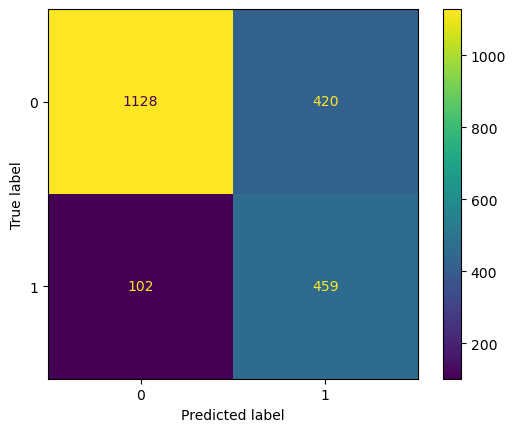

In [333]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [334]:
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
# Evaluation
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
precision = precision_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")

ROC AUC: 0.77
F1 Score: 0.64
Recall score: 0.82
precision : 0.52
Accuracy: 0.75
Corr : 0.4901164073034074


In [335]:
roc_auc,f1,recall,accuracy,coef

(0.773431994362227,
 0.6375,
 0.8181818181818182,
 0.7524893314366998,
 0.4901164073034074)